In [8]:
from spirit import simulation, state,quantities, hamiltonian,parameters,geometry,configuration,system,io
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mp
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

dim = 10
concentration = 25

def plot_loop(H_relax):
    Hmax = 1
    H_step = 0.1
    iterations_per_step = 1  # Take this many Metropolis iterationss per lattice site between each check for convergence
    # Now is Ht transverse fields, max is  = 1T

    # fields = np.arange(Hmax,Hfine1,-1*Hstep_coarse,dtype=float)
    # fields = np.append(fields,np.arange(Hfine1,Hfine2,-1*Hstep_fine,dtype=float))
    # fields = np.append(fields,np.arange(Hfine2,-1*Hmax,-1*Hstep_coarse,dtype=float))
    # fields_hyst = np.append(fields,-1*fields)
    # fields_hyst = np.tile(fields_hyst, n_cycles)

    Hz = 0.0  # Longitudinal field
    output_interval = 1  # Interval at which spin configuration files are saved
    fn = "dipolar_arr"
    prefix = "DDI_exp_14_G0p00005_Ht10p0"

    mu = 7

    with state.State(f"input/LHF_DDI_glass_14_{concentration}_tunnel_{dim}.cfg") as p_state:
        types = geometry.get_atom_types(p_state)
        nos = types.size
        print(f"Sites: {nos}  Spins: {nos+np.sum(types)}")
        locs = geometry.get_positions(p_state)
        np.savetxt("output/"+prefix+"atom_locs.csv",locs,delimiter=",")
        np.savetxt("output/"+prefix+"atom_types.csv",types,delimiter=",")
    #    write_config(p_state,prefix)
        parameters.mc.set_metropolis_cone(p_state, use_cone=True, cone_angle=30, use_adaptive_cone=True)
        parameters.mc.set_metropolis_spinflip(p_state, False)

        # parameters.mc.set_tunneling_gamma(p_state, tunneling_gamma=0.00012)

        # For trying without tunneling and at base temperature ~0K
        parameters.mc.set_use_tunneling(p_state, False)
        parameters.mc.set_temperature(p_state, 0.000035)

        #We'll evaluate convergence after enough Metropolis steps to hit each site twitce on average
        parameters.mc.set_iterations(p_state,iterations_per_step*types.size,iterations_per_step*types.size)

        #Initialize in the random state
        configuration.random(p_state)

    ## Import the DDI interaction arrays
    #    path_arr_x = os.path.join("input/", fn +"_DDI_x.npy")
    #    path_arr_y = os.path.join("input/", fn +"_DDI_y.npy")
    #    path_arr_z = os.path.join("input/", fn +"_DDI_z.npy")
        path_arr_x = os.path.join(f"dipolar_interaction_matrices_reordered/{dim}_{dim}_{dim}/", fn +"_x.npy") #fn = dipolar_arr
        path_arr_y = os.path.join(f"dipolar_interaction_matrices_reordered/{dim}_{dim}_{dim}/", fn +"_y.npy")
        path_arr_z = os.path.join(f"dipolar_interaction_matrices_reordered/{dim}_{dim}_{dim}/", fn +"_z.npy")

        if os.path.exists(path_arr_x) and os.path.exists(path_arr_y) and os.path.exists(path_arr_z):
            print("loading DDI interaction data.")
            DDI_interaction_x = np.load(path_arr_x)
            DDI_interaction_y = np.load(path_arr_y)
            DDI_interaction_z = np.load(path_arr_z)
        else:
            print("DDI files not found")
    #        break

    #Check that the size of the DDI arrays matches NOS (extracted from the types array above).
        if (nos != DDI_interaction_x.shape[0]) or (nos != DDI_interaction_y.shape[0]) or (nos != DDI_interaction_z.shape[0]) :
            print("Size mismatch between DDI and spin array")
    #        break
    #Filter out any vacant sites
        vacancies_idx = np.where(types == -1)
        locs[:,0][vacancies_idx] = 0
        locs[:,1][vacancies_idx] = 0
        locs[:,2][vacancies_idx] = 0

        Hz = 0.0
        Hts = np.arange(Hmax, H_relax-1 * H_step, -1 * H_step, dtype=float)
        for i,Ht in enumerate(Hts):
            print(f'Ht: {Ht:.3f}', concentration)

            Hmag = np.sqrt(Hz*Hz + Ht*Ht)
            hamiltonian.set_field(p_state,Hmag,(Ht,0,Hz)) #Inside set_field, the vector is normalized, so we don't have to do that here

            spins = system.get_spin_directions(p_state)  #Get the current spin state to update the DDI fields from the Ewald sum
            spins[:,2][vacancies_idx] = 0   #For LHF, we only care about Sz, but zero out the moments for vacancy site
            spins[:,1][vacancies_idx] = 0   #For LHF, we only care about Sz, but zero out the moments for vacancy site
            spins[:,0][vacancies_idx] = 0   #For LHF, we only care about Sz, but zero out the moments for vacancy site

            #Calculate the DDI field components, and then send to the SPIRIT engine. DDI interaction calculations are in Oe, SPIRIT
            #uses T, so need to scale accordingly.
            #Get the field at each spin. Only care about DDI due to z-spin so use spins[:,2]
            DDI_field_x_from_z = np.matmul(DDI_interaction_x, spins[:, 2]) * 7 / 1e4  # V_xz
            DDI_field_y_from_z = np.matmul(DDI_interaction_y, spins[:, 2]) * 7 / 1e4  # V_yz
            DDI_field_z_from_z = np.matmul(DDI_interaction_z, spins[:, 2]) * 7 / 1e4  # V_zz

            # DDI_field_x_from_y = np.matmul(DDI_interaction_x, spins[:, 1]) * 7 / 1e4 #V_xy
            # DDI_field_y_from_y = np.matmul(DDI_interaction_y, spins[:, 1]) * 7 / 1e4 #V_yy
            DDI_field_z_from_y = np.matmul(DDI_interaction_y.T, spins[:, 1]) * 7 / 1e4  # V_zy

            # DDI_field_x_from_x = np.matmul(DDI_interaction_x, spins[:, 0]) * 7 / 1e4 #V_xx
            # DDI_field_y_from_x = np.matmul(DDI_interaction_y, spins[:, 0]) * 7 / 1e4 #V_yx
            DDI_field_z_from_x = np.matmul(DDI_interaction_x.T, spins[:, 0]) * 7 / 1e4  # V_zx

            DDI_field_z_total = DDI_field_z_from_z + DDI_field_z_from_y + DDI_field_z_from_x

            # Pass into SPIRIT
            DDI_field_interleave = np.ravel(np.column_stack((DDI_field_x_from_z, DDI_field_y_from_z, DDI_field_z_total)))
            system.set_DDI_field(p_state,n_atoms=nos,ddi_fields=DDI_field_interleave)

            ####Less strict convergence check conditions to simulate spin glass not relaxing to equilibrium state
            # converge_threshold = 0.01 #Fractional change in magnetization between steps to accept convergence
            converge_threshold = 0.01  # Fractional change in magnetization between steps to accept convergence
            # converge_max = 20 #Maximum number of steps to take before moving on
            converge_max = 10  # Maximum number of steps to take before moving on

            # Stricter convergence check for relaxation step
            converge_threshold_relax = 0.0001
            converge_max_relax = 80

            #For relaxing at H_relax
            if Ht <= H_relax:
                converge_max = converge_max_relax
                converge_threshold = converge_threshold_relax

            #Check convergence, same as old hysteresis_loop. But METHOD_MC now uses tunnelling since we set tunnel flag to 1 in cfg files
            for j in range(converge_max):
                simulation.start(p_state, simulation.METHOD_MC, single_shot=False) #solver_type=simulation.MC_ALGORITHM_METROPOLIS
                simulation.stop(p_state)
                if j == 0 :
                    m_temp = quantities.get_magnetization(p_state)[2]
                else :
                    m_prev = m_temp
                    m_temp = quantities.get_magnetization(p_state)[2]
     #               ratio = abs((m_temp-m_prev)/m_prev)
                    ratio = abs((m_temp-m_prev)/mu)
                    print(f"Iteration: {j:d}, Convergence: {ratio:.4f}, M_z: {m_temp:.4f}")
                    if ratio<converge_threshold :
                        break

            if output_interval>0: #Output the spin configuration.
                #TODO: Use system.get_spin_directions to pull the configuration array into Python, and then save out as an npy or similar
                if (i % output_interval == 0):
                    tag = prefix+f'N{i:d}_H{Hz:.3f}'
                    name = "output/" + tag + "_Image-00_Spins_0.ovf" #To match the internally-generated naming format
                    io.image_write(p_state,filename=name)

        spins = system.get_spin_directions(p_state)  # Get the current spin state to update the DDI fields from the Ewald sum
        spins[:, 2][vacancies_idx] = 0  # For LHF, we only care about Sz, but zero out the moments for vacancy site
        spins[:, 1][vacancies_idx] = 0  # For LHF, we only care about Sz, but zero out the moments for vacancy site
        spins[:, 0][vacancies_idx] = 0  # For LHF, we only care about Sz, but zero out the moments for vacancy site

        DDI_field_x_from_z = np.matmul(DDI_interaction_x, spins[:, 2]) * 7 / 1e4
        DDI_field_y_from_z = np.matmul(DDI_interaction_y, spins[:, 2]) * 7 / 1e4
        DDI_field_z_from_z = np.matmul(DDI_interaction_z, spins[:, 2]) * 7 / 1e4

        DDI_field_z_from_y = np.matmul(DDI_interaction_y.T, spins[:, 1]) * 7 / 1e4  # V_zy
        DDI_field_z_from_x = np.matmul(DDI_interaction_x.T, spins[:, 0]) * 7 / 1e4  # V_zx

        DDI_field_z_total = DDI_field_z_from_z + DDI_field_z_from_y + DDI_field_z_from_x

        DDI_field_trans = np.sqrt(DDI_field_x_from_z ** 2 + DDI_field_y_from_z ** 2)

        # Remove vacant site data from output arrays
        valid_idx = np.setdiff1d(np.arange(spins.shape[0]), vacancies_idx)
        spins = np.delete(spins, vacancies_idx, axis=0)

    return pd.DataFrame({
        'Ht': H_relax * np.ones(len(valid_idx)),
        'DDI_field_z': DDI_field_z_total[valid_idx],
        'DDI_field_trans': DDI_field_trans[valid_idx]
    }), spins

In [9]:
df, spins = plot_loop(0.5)

2025-07-08 11:26:31  [  ALL  ] [ALL ] [--] [--]  =====================================================
                                                 ========== Spirit State: Initialising... ============
                                                 ==========     Version:  2.2.0
                                                 ==========     Revision: 57bb4f9adb68c
2025-07-08 11:26:31  [  ALL  ] [ALL ] [--] [--]  Config file: "input/LHF_DDI_glass_14_25_tunnel_10.cfg"
2025-07-08 11:26:31  [  ALL  ] [ALL ] [--] [--]  =====================================================
2025-07-08 11:26:31  [WARNING] [ IO ] [--] [--]  Keyword 'lattice_rng_seed' not found. Using Default: 234721471
2025-07-08 11:26:31  [WARNING] [ IO ] [--] [--]  4 atom types, iatom=0 atom type=0 concentration=0.25
2025-07-08 11:26:31  [WARNING] [ IO ] [--] [--]  Keyword 'mc_seed' not found. Using Default: -1250966875
2025-07-08 11:26:31  [WARNING] [ IO ] [--] [--]  Keyword 'ema_sparse' not found. Using Default: fals

In [10]:
for row in spins:
    print(row)

[-0.72537493  0.63705217  0.26075992]
[-0.49937858  0.82987149 -0.2488661 ]
[ 0.0924391   0.99466525 -0.04578264]
[ 0.11969268 -0.22770742 -0.96634517]
[-0.61122876  0.23824253 -0.75474492]
[-0.81957825  0.44792701  0.35728543]
[-0.80753761  0.48176077  0.34027866]
[-0.30788564 -0.68107563 -0.66433608]
[-0.99593707 -0.08795066  0.01934014]
[-0.79320793 -0.06576958 -0.60538875]
[ 0.73025426  0.57858321 -0.36327702]
[-0.45455762  0.28884064 -0.84258439]
[-0.88377218 -0.46323972  0.06599773]
[-0.17971027  0.92898288  0.32356611]
[-0.96034181  0.11906665 -0.25212446]
[-0.88911356 -0.14410808 -0.43440758]
[-0.11791677 -0.805451    0.5808135 ]
[-0.14919944  0.45903358 -0.87580118]
[ 0.18621591  0.67936259 -0.70978173]
[-0.45652837 -0.80403336  0.38093595]
[ 0.40780845 -0.75312286  0.51623467]
[ 0.92765574 -0.37224903  0.02975721]
[-0.98697868 -0.11620488  0.11121833]
[-0.25513698 -0.74615132 -0.61494986]
[0.96500223 0.20498784 0.16355639]
[ 0.83237566  0.48121205 -0.27492858]
[-0.99376622 -0

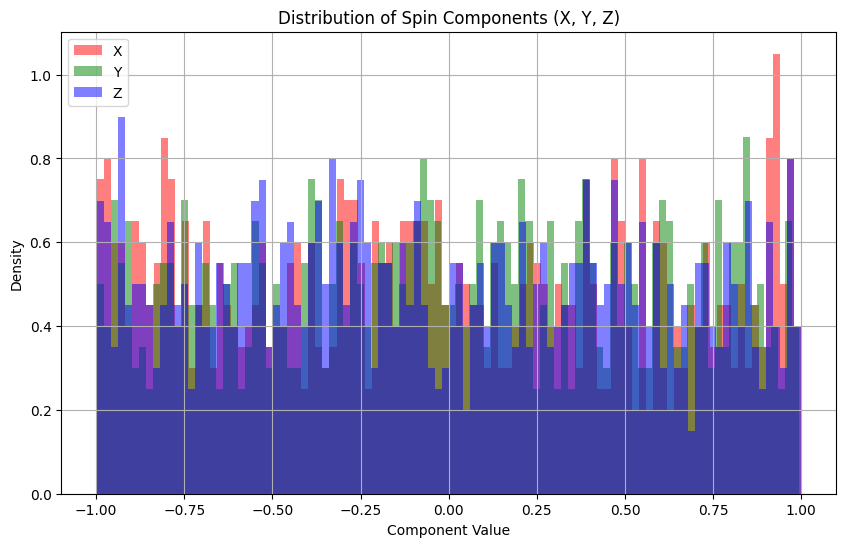

In [12]:

# Extract components
x_vals = spins[:, 0]
y_vals = spins[:, 1]
z_vals = spins[:, 2]

# Plot histograms
plt.figure(figsize=(10, 6))
bins = 100

plt.hist(x_vals, bins=bins, alpha=0.5, label='X', color='red', density=True)
plt.hist(y_vals, bins=bins, alpha=0.5, label='Y', color='green', density=True)
plt.hist(z_vals, bins=bins, alpha=0.5, label='Z', color='blue', density=True)

plt.title("Distribution of Spin Components (X, Y, Z)")
plt.xlabel("Component Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()